### Please read the OpenAI documenation for "Embeddings" at this page: https://platform.openai.com/docs/guides/embeddings/use-cases 

---

If you only want your API key to be accessible to a single project, you can create a local .env file which contains the API key and then explicitly use that API key with the Python code shown in the steps to come.

Start by going to the project folder you want to create the .env file in.

In order for your .env file to be ignored by version control, create a .gitignore file in the root of your project directory. Add a line with .env on it which will make sure your API key or other secrets are not accidentally shared via version control.
Once you create the .gitignore and .env files using the terminal or an integrated development environment (IDE), copy your secret API key and set it as the OPENAI_API_KEY in your .env file. If you haven't created a secret key yet, you can do so on the API key page.

The .env file should look like the following:
```

# Once you add your API key below, make sure to not share it with anyone! The API key should remain private.

OPENAI_API_KEY=abc123

```

The API key can be imported by running the code below:
```
from openai import OpenAI

client = OpenAI()
# defaults to getting the key using os.environ.get("OPENAI_API_KEY")
# if you saved the key under a different environment variable name, you can do something like:
# client = OpenAI(
#   api_key=os.environ.get("CUSTOM_ENV_NAME"),
# )
```

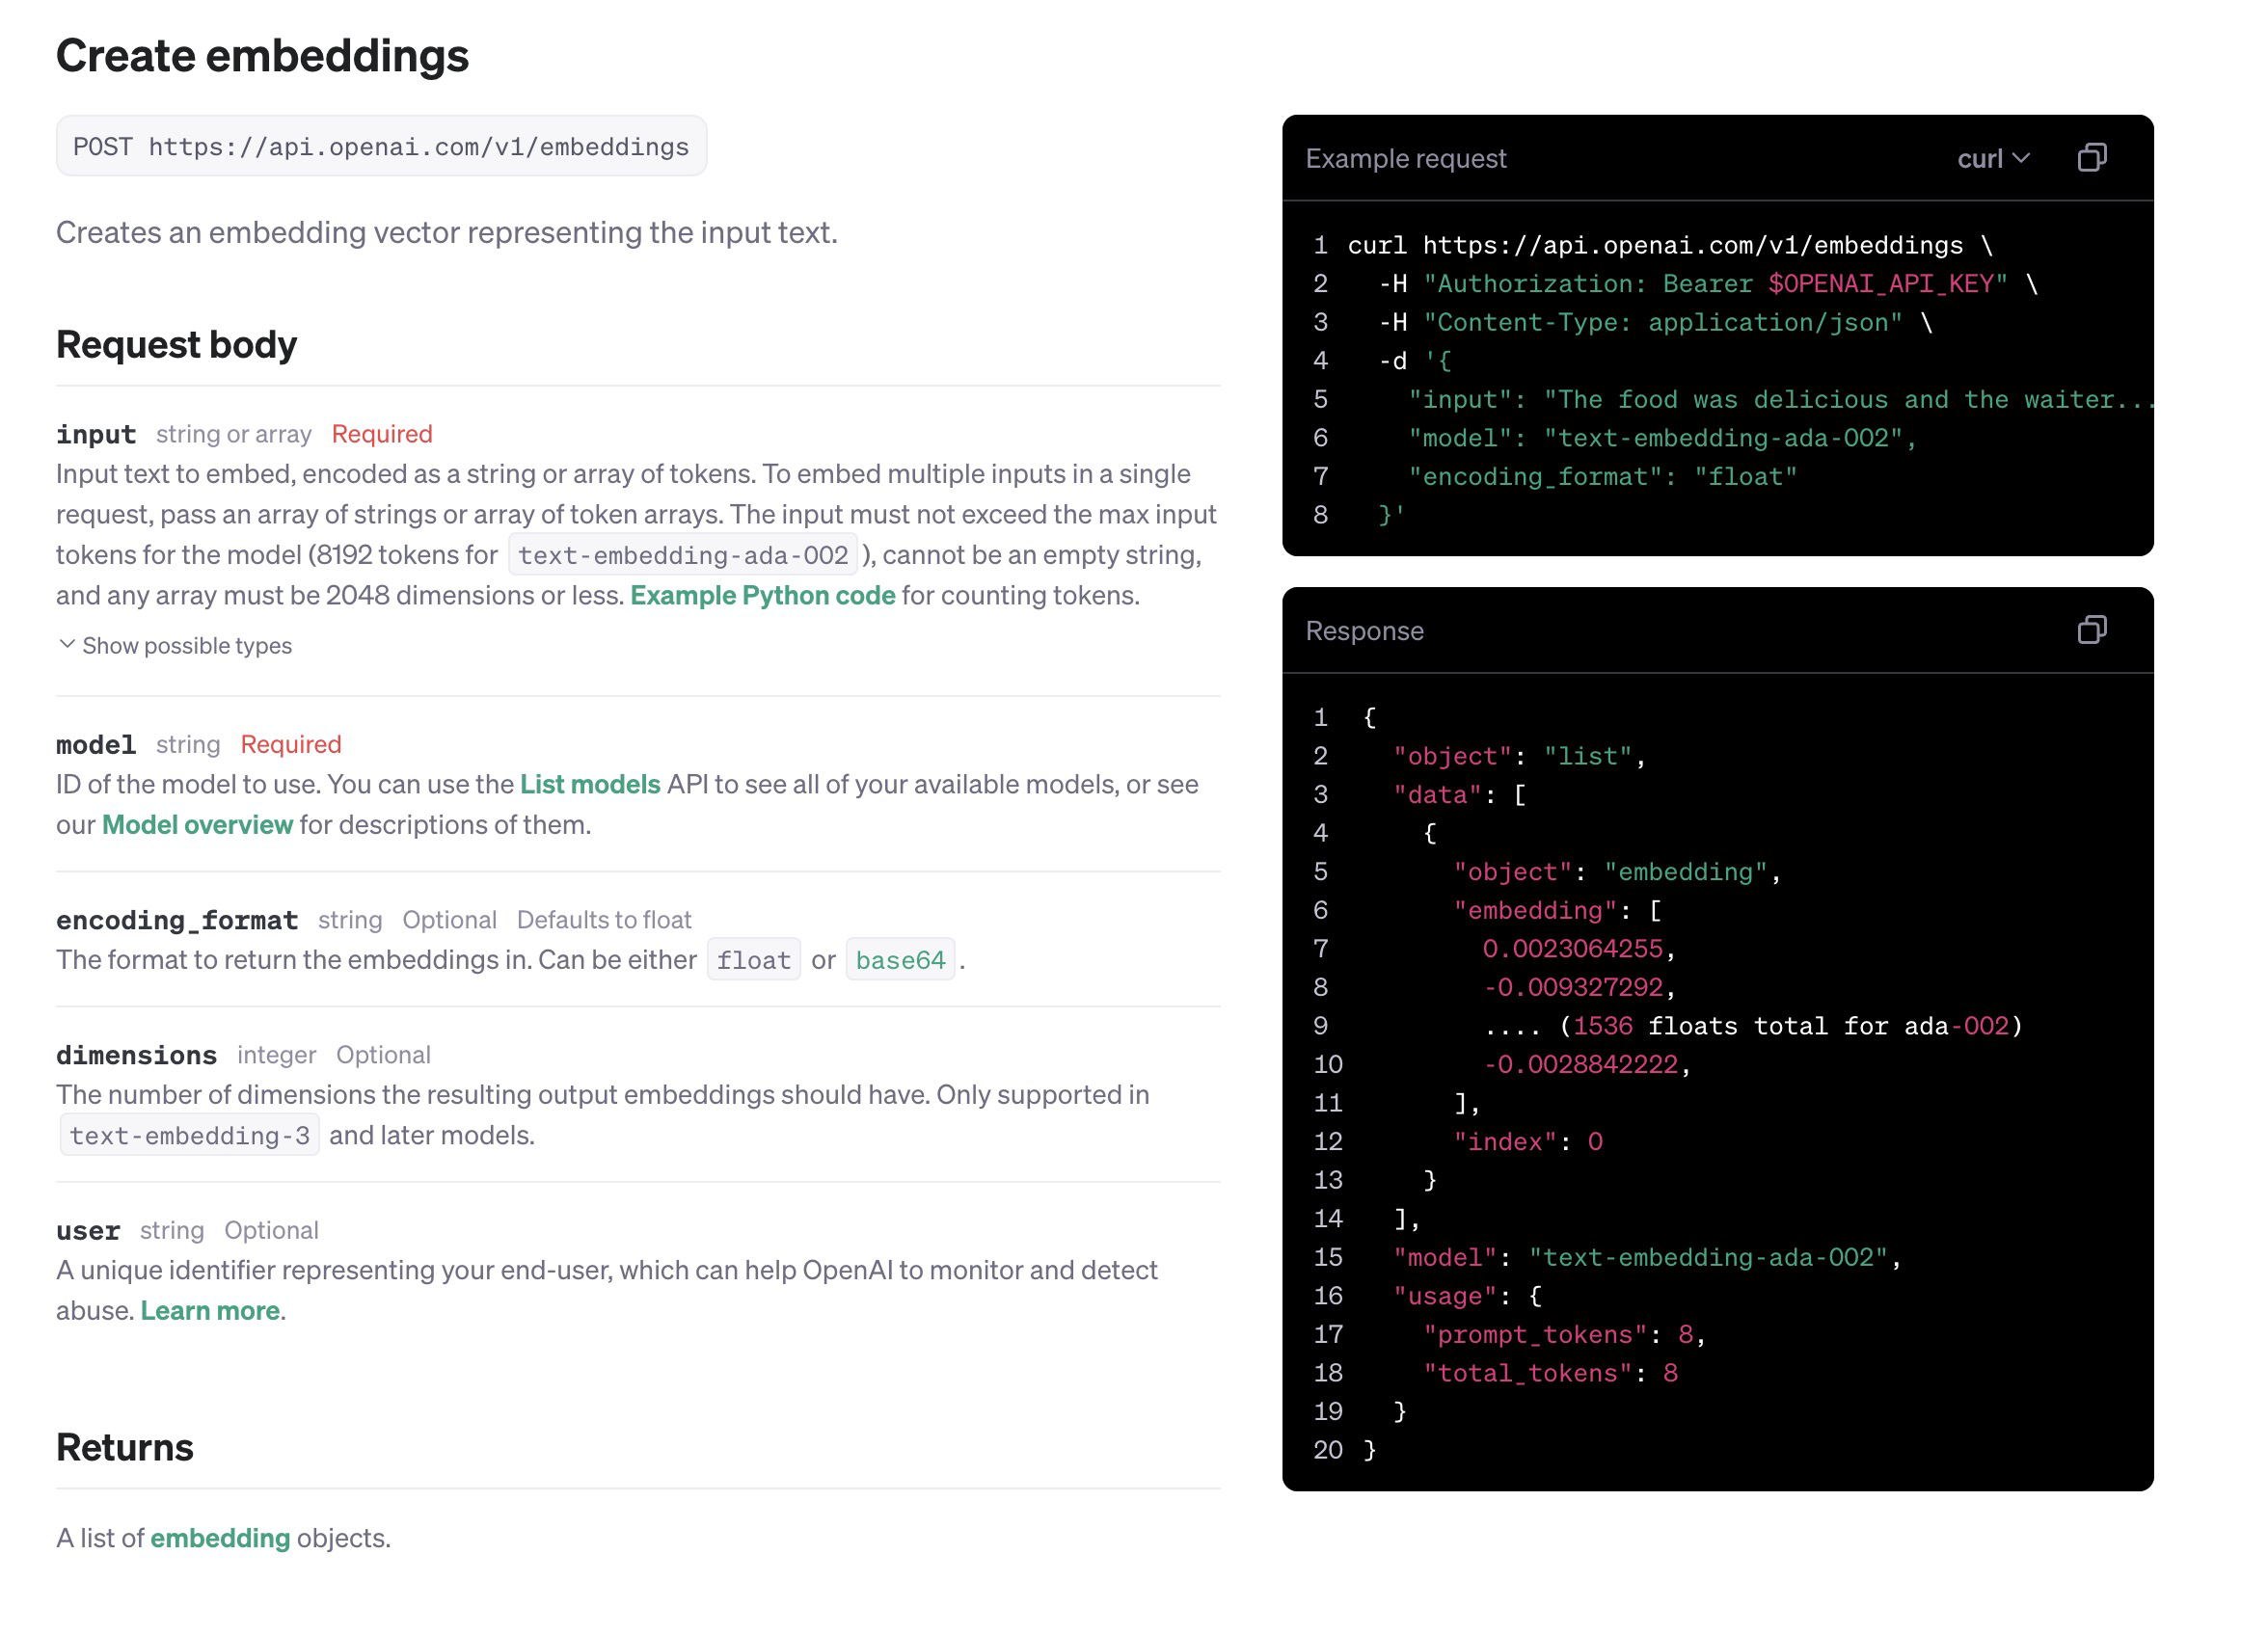

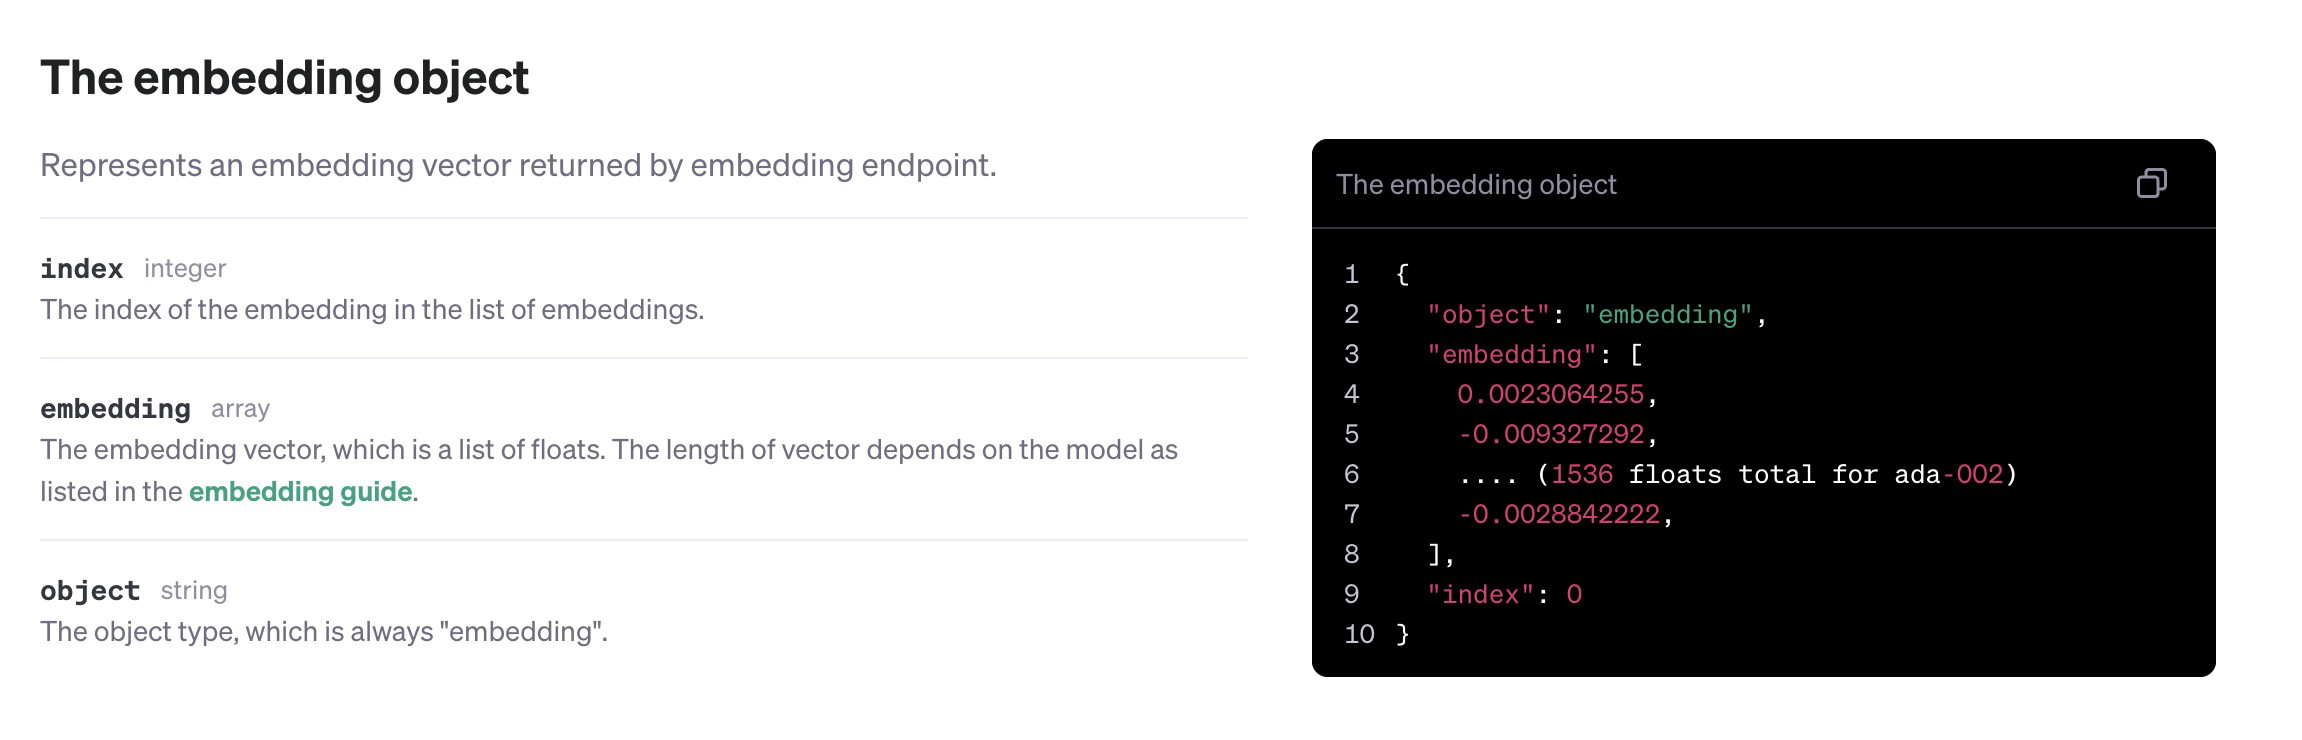

In [1]:
from utils import NUM_TOKENS
from openai import OpenAI
import numpy as np
import tiktoken

CUDA device found.


In [12]:
client = OpenAI()

def get_embedding(text, model="text-embedding-3-small", dimensions=NUM_TOKENS):
   text = text.replace("\n", " ")
   return client.embeddings.create(input = [text], model=model, dimensions=dimensions).data[0].embedding

embd = get_embedding('hello world!')

print(f"embd (type, len, norm): {type(embd), len(embd), np.linalg.norm(embd)}\n")

2024-04-25 16:27:50,332 - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"


embd (type, len, norm): (<class 'list'>, 256, 1.0000000376280906)



In general, using the dimensions parameter when creating the embedding is the suggested approach. In certain cases, you may need to change the embedding dimension after you generate it. When you change the dimension manually, you need to be sure to normalize the dimensions of the embedding as is shown below.

In [13]:
client = OpenAI()

def normalize_l2(x):
    x = np.array(x)
    if x.ndim == 1:
        norm = np.linalg.norm(x)
        if norm == 0:
            return x
        return x / norm
    else:
        norm = np.linalg.norm(x, 2, axis=1, keepdims=True)
        return np.where(norm == 0, x, x / norm)


response = client.embeddings.create(
    model="text-embedding-3-small", input="Testing 123", encoding_format="float"
)

cut_dim = response.data[0].embedding[:256]
norm_dim = normalize_l2(cut_dim)

print(f"(type, len, norm): {type(norm_dim), len(norm_dim), np.linalg.norm(norm_dim)}\n")

2024-04-25 16:27:50,503 - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"


(type, len, norm): (<class 'numpy.ndarray'>, 256, 1.0)



Dynamically changing the dimensions enables very flexible usage. For example, when using a vector data store that only supports embeddings up to 1024 dimensions long, developers can now still use our best embedding model text-embedding-3-large and specify a value of 1024 for the dimensions API parameter, which will shorten the embedding down from 3072 dimensions, trading off some accuracy in exchange for the smaller vector size.

In [14]:
# How can I tell how many tokens a string has before I embed it?
# In Python, you can split a string into tokens with OpenAI's tokenizer tiktoken.

# Example code:

def num_tokens_from_string(string: str, encoding_name: str) -> int:
    """Returns the number of tokens in a text string."""
    encoding = tiktoken.get_encoding(encoding_name)
    num_tokens = len(encoding.encode(string))
    return num_tokens

num_tokens_from_string("tiktoken is great!", "cl100k_base")

# For third-generation embedding models like text-embedding-3-small, use the cl100k_base encoding.
# More details and example code are in the OpenAI Cookbook guide how to count tokens with tiktoken.

tokenizer = tiktoken.get_encoding("cl100k_base")
print("vocabulary size:", tokenizer.n_vocab)
tokenizer.encode("hello world!")

6